In [1596]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import h5py

SAVE_PLOTS = False

# Setup Parameters

Hamamatsu S13360-6025 SiPM

Voltage: $55.5 V$, Current: $
\approx 0.06 \mu A$

Trigger height: $2.32mV$, div $20mV$/$10 \mu s$


In [ ]:
def get_default_filename():
    # get the newest file of the kind: analysis\data\sipm_spectroscopy\vp2ps_20250316-171204.csv
    import os
    import glob
    import re
    path = r'data\sipm_spectroscopy'
    files = glob.glob(path + '\*.csv')
    files.sort(key=os.path.getmtime)
    return files[-1]


vp2p_path = get_default_filename()
# vp2p_path = r'data\sipm_spectroscopy\vp2ps_20250323-150545_co60_18h.csv'
df = pd.read_csv(vp2p_path)
df.head(1)

,Unnamed: 0,t,V
0,0,1.742806e+09,0.0164


In [1598]:

df['mV'] = df['V']*1000
mV_low_cut = 10
mV_high_cut = 50
df = df.loc[(df['mV'] > mV_low_cut) & (df['mV'] < mV_high_cut)].dropna()

df['t'] = [datetime.fromtimestamp(t) for t in df['t']]
df['t'] = pd.to_datetime(df['t'])
df = df.sort_values(by='t')

In [1599]:
def print_stats():
    time_diff = (df['t'].iloc[-1] - df['t'].iloc[0]).seconds / 60
    avg_data_points_per_minute = df.shape[0] / time_diff

    print(f'Number of data points: {df.shape[0]}')
    print(f'Start time: {df["t"].iloc[0]}')
    print(f'End time: {df["t"].iloc[-1]}')
    print(f'Average number of data points per minute: {avg_data_points_per_minute:.2f}')
    print(f'Average number of data points per hour: {avg_data_points_per_minute * 60:.2f}')
    print(f'Total time of measurement: {time_diff // 60:.0f} hours and {time_diff % 60:.0f} minutes')
print_stats()

Number of data points: 15668
Start time: 2025-03-24 09:50:00.587604
End time: 2025-03-24 15:27:15.517469
Average number of data points per minute: 46.46
Average number of data points per hour: 2787.62
Total time of measurement: 5 hours and 37 minutes


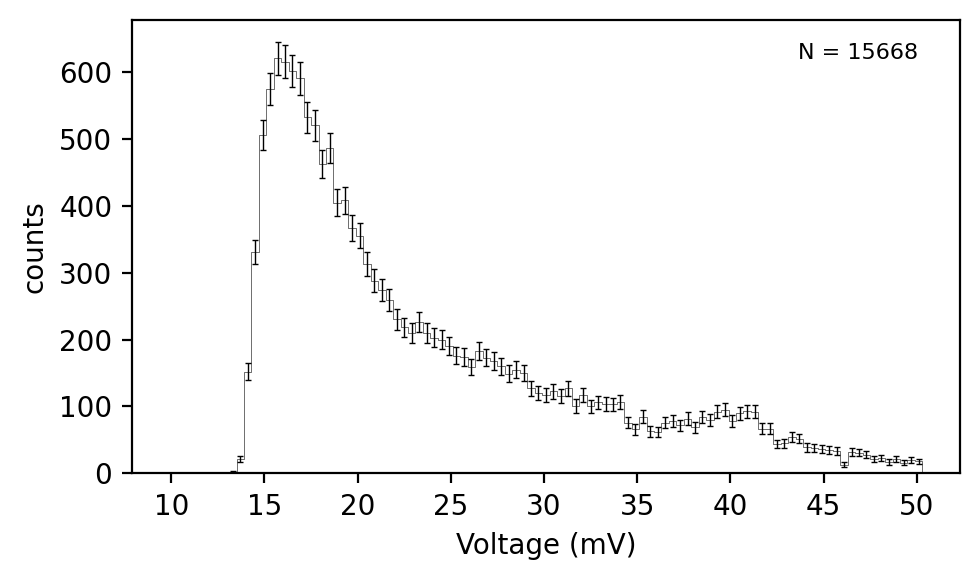

In [1600]:

fig, ax = plt.subplots(1,1, figsize=(5,3), dpi=200)

step = 0.4
hist_min = mV_low_cut
hist_max = mV_high_cut
bins = np.arange(hist_min - 0.1, hist_max + step, step)

count, bins, _ = ax.hist(df['mV'], bins=bins, color='black', histtype='step', linewidth=0.2, range=(hist_min, hist_max))
errors = np.sqrt(count)
bin_centers = (bins[1:] + bins[:-1]) / 2
ax.errorbar(bin_centers, count, yerr=errors, fmt='none', color='black', capsize=1, capthick=0.5, elinewidth=0.5)

# rescale the x axis by 1000 to convert from V to mV
# ax.set_xticks(ax.get_xticks()*1000)
ax.set_xlabel('Voltage (mV)')
ax.set_ylabel('counts')
plt.tight_layout()


# display the number of entries in the upper right corner of the plot
n_entries = df.shape[0]
ax.text(0.95, 0.95, f'N = {n_entries}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=8)

ax.set_xlabel('Voltage (mV)')
ax.set_ylabel('counts')
plt.tight_layout()
if SAVE_PLOTS:
    save_dir = f'plots/sipm_spectroscopy/preliminary/threshhold_4pt4mV'
    ax.set_yscale('log')
    plt.savefig(f'{save_dir}/spectrum_Co60_10mins_log.png', dpi=200)
    ax.set_yscale('linear')
    plt.savefig(f'{save_dir}/spectrum_Co60_10mins.png', dpi=200)

plt.show()

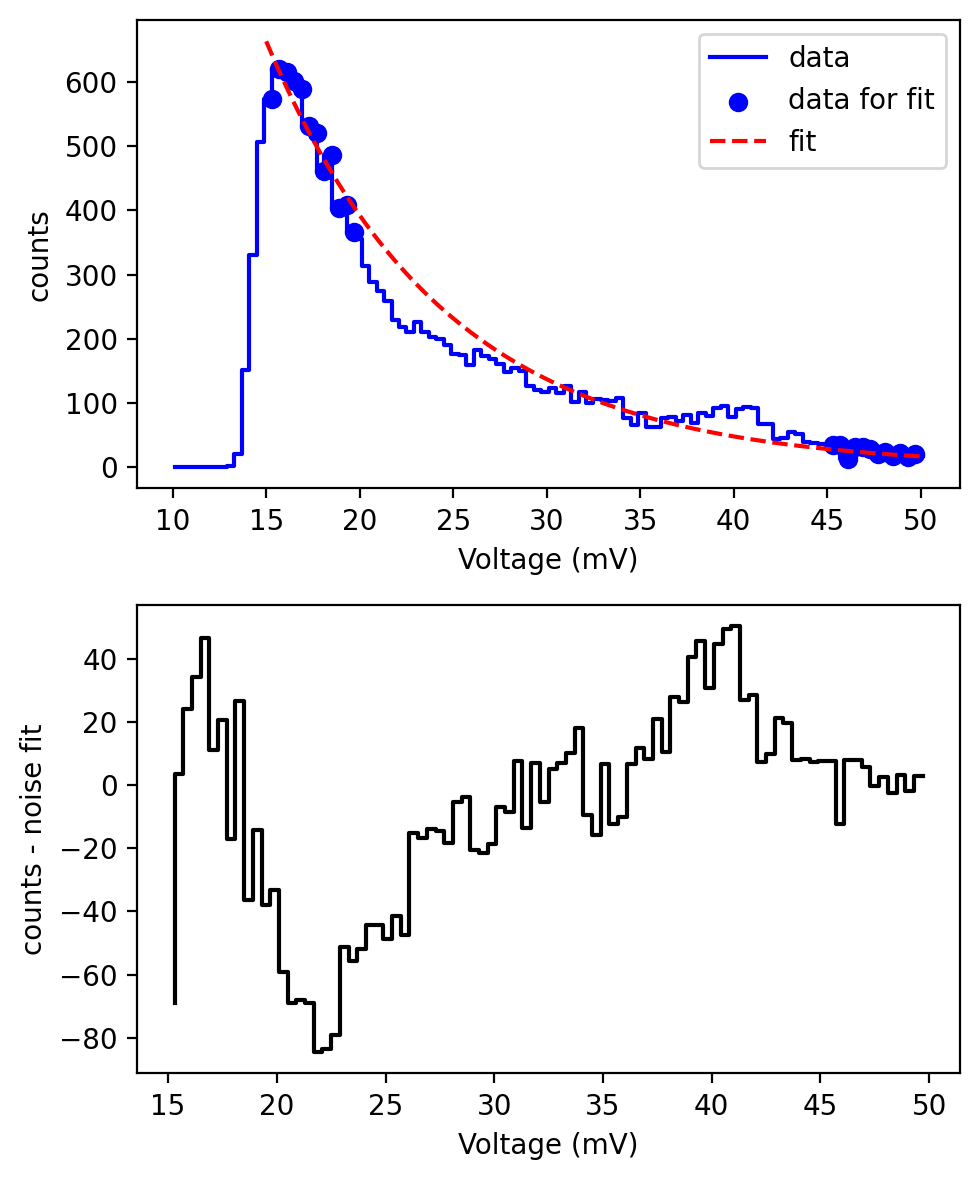

In [1601]:
bin_centers = pd.Series(bins[:-1] + bins[1:], name='V') / 2
df= pd.DataFrame({'V': bin_centers, 'count': count})

fig, ax = plt.subplots(2,1, figsize=(5,6), dpi=200)
ax[0].step(df['V'], df['count'], color='b',label = 'data')

# df_fit = df where V > 20 and V < 100 or V > 200 and V < 300

min1 = 15
max1 = 20
min2 = 45
max2 = 50
df_fit = df.loc[(df['V'] > min1) & (df['V'] < max1) | (df['V'] > min2) & (df['V'] < max2)]
ax[0].scatter(df_fit['V'], df_fit['count'], color='b', label='data for fit')

# fit an exponential function to the data
from scipy.optimize import curve_fit
def exp_fit(x, a, b):
    return a * np.exp(-b * x)

popt, pcov = curve_fit(exp_fit, df_fit['V'], df_fit['count'], p0=[1000, 0.1])
popt

x_fit = np.linspace(min1, max2, 100)
ax[0].plot(x_fit, exp_fit(x_fit, *popt), linestyle='--', color='r',label='fit')

ax[0].set_xlabel('Voltage (mV)')
ax[0].set_ylabel('counts')
ax[0].legend()

df_sub = df.loc[(df['V'] > 15) & (df['V'] < 50)].copy()
df_sub['count'] = df_sub['count'] - exp_fit(df_sub['V'], *popt)
ax[1].step(df_sub['V'], df_sub['count'], color='black')
ax[1].set_xlabel('Voltage (mV)')
ax[1].set_ylabel('counts - noise fit')
plt.tight_layout()
plt.show()
